# Предсказание рыночной стоимости автомобиля
## Описание проекта
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
Необходимо построить модель, которая умеет её определять. Для обучения модели предполагается использовать датасет с данными о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
* качество предсказания;
* время обучения модели;
* время предсказания модели.

Для выбора лучшей модели следует использовать метрику качества RMSE - корень из среднего квадрата ошибки.

## Импорт библиотек
Загрузим необходимые библиотеки.

In [1]:
!pip install lightgbm
!pip install catboost

from pathlib import Path
import re

import pandas as pd
pd.set_option('display.float_format', '{:,.2f}'.format)

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

from catboost import CatBoostRegressor
import lightgbm as lgb


## Импорт и первичное исследование данных
### Импорт данных


In [2]:
my_path = Path('/home/klarazetkin/Documents/yandex/module_4/project_2')
file_name = str(my_path) + '/' + 'autos.csv'
if my_path.is_dir():
    df = pd.read_csv(file_name)
else:
    df = pd.read_csv('/datasets/autos.csv')
    
# сохраним резервную копию исходного датасета
df_original = df 

### Первичное исследование
Датасет состоит из 16 колонок и 354369 строк, которые соответствуют объектам - выставленным на продажу машинам.

**Обучающие признаки:**
    
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак**, который должна будет предсказать модель, - 
* Price — цена (евро)

Типы данных в основном адекватны; стоит заменить тип 'object' в колонке 'Repaired' на 'boolean'.

В колонке 'RegistrationYear' есть явные выбросы - ошибочные данные. То же и в колонке 'Power'.

Датасет имеет большое количество отсутствующих значений: 11% в колонке VehicleType, 6% в Gearbox, 6% в Model, 9% в FuelType, 20% в Repaired.

Кроме того, среди объектов есть 4 полных дубликата.

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.shape

(354369, 16)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,"354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00"
mean,"4,416.66","2,004.23",110.09,"128,211.17",5.71,0.00,"50,508.69"
std,"4,514.16",90.23,189.85,"37,905.34",3.73,0.00,"25,783.10"
min,0.00,"1,000.00",0.00,"5,000.00",0.00,0.00,"1,067.00"
25%,"1,050.00","1,999.00",69.00,"125,000.00",3.00,0.00,"30,165.00"
50%,"2,700.00","2,003.00",105.00,"150,000.00",6.00,0.00,"49,413.00"
75%,"6,400.00","2,008.00",143.00,"150,000.00",9.00,0.00,"71,083.00"
max,"20,000.00","9,999.00","20,000.00","150,000.00",12.00,0.00,"99,998.00"


In [7]:
df.duplicated().sum()

4

In [8]:
df.isna().mean()

DateCrawled         0.00
Price               0.00
VehicleType         0.11
RegistrationYear    0.00
Gearbox             0.06
Power               0.00
Model               0.06
Kilometer           0.00
RegistrationMonth   0.00
FuelType            0.09
Brand               0.00
Repaired            0.20
DateCreated         0.00
NumberOfPictures    0.00
PostalCode          0.00
LastSeen            0.00
dtype: float64

## Проверка корреляций в исходном датасете
### Тепловая карта и матрица корреляций
Построим тепловую карту и матрицу корреляций. 

Из построенных графиков видно, что корреляции довольно слабые. Самая сильная - обратная корреляция цены и пробега автомобиля (коэффициент корреляции -0.33). 

Вероятно, данные зашумлены выбросами.

In [9]:
# функция печати тепловой карты коэффициентов корреляции
def correlation_heatmap(dataframe):
    plt.figure(figsize=(18, 7))

    sns.heatmap(dataframe, annot=True, fmt=".5f", linewidths=.1, cmap='RdYlGn')
    plt.title('Матрица коэффициентов корреляции', fontsize=15)
    plt.ylabel('Признак', fontsize=15)
    plt.xlabel('Признак', fontsize=15)

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.00,0.03,0.16,-0.33,0.11,NaN,0.08
RegistrationYear,0.03,1.00,-0.00,-0.05,-0.01,NaN,-0.00
Power,0.16,-0.00,1.00,0.02,0.04,NaN,0.02
Kilometer,-0.33,-0.05,0.02,1.00,0.01,NaN,-0.01
RegistrationMonth,0.11,-0.01,0.04,0.01,1.00,NaN,0.01
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.08,-0.00,0.02,-0.01,0.01,NaN,1.00


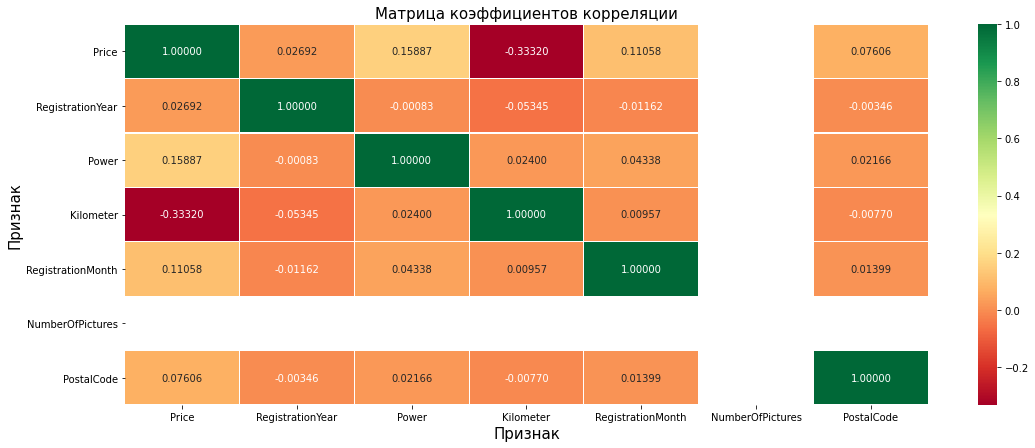

In [10]:
display(df.corr())
correlation_heatmap(df.corr())

In [11]:
# функция печати матрицы диаграмм рассеяния
def scatter_matrix(dataframe):
    pd.plotting.scatter_matrix(
        dataframe, 
        figsize=(12, 12)
    )

/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:89: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:90: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


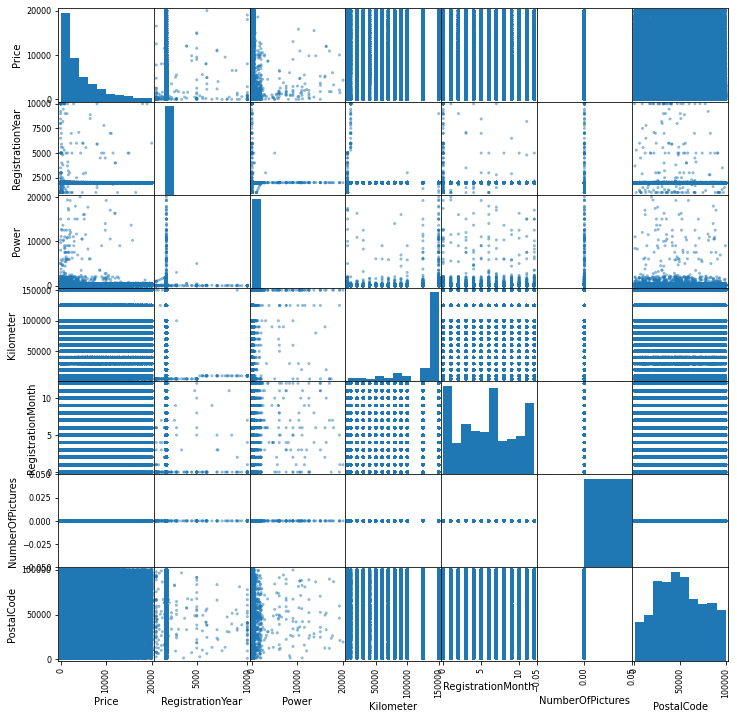

In [12]:
scatter_matrix(df)

In [13]:
def print_hist(data_as_column, title='График распределения', bins=100):
      ax = data_as_column.hist(bins=bins)
      ax.set_title(title)
      ax.set_ylabel('Объекты датасета')

## Предобработка данных
### Переименование столбцов
Признаки поименованы в CamelCase, для большего удобства переведем названия в snake_case.

In [14]:
df = df.rename(columns={'DateCrawled': 'crawled_at', 'Price': 'price', 'VehicleType': 'vehicle_type', 'RegistrationYear': 'registration_year', 'Gearbox': 'gearbox', 'Power': 'power', 'Model': 'model', 'Kilometer': 'kilometer', 'RegistrationMonth': 'registration_month', 'FuelType': 'fuel_type', 'Brand': 'brand', 'Repaired': 'repaired', 'DateCreated': 'created_at', 'NumberOfPictures': 'number_of_pictures', 'PostalCode': 'postal_code', 'LastSeen': 'last_seen_at'})

In [15]:
def convert_to_snake_case(camel_input):
    words = re.findall(r'[A-Z]?[a-z]+|[A-Z]{2,}(?=[A-Z][a-z]|\d|\W|$)|\d+', camel_input)
    return '_'.join(map(str.lower, words))


# Let's test it
test_strings = [
    'CamelCase',
    'camelCamelCase',
    'Camel2Camel2Case',
    'getHTTPResponseCode',
    'get200HTTPResponseCode',
    'getHTTP200ResponseCode',
    'HTTPResponseCode',
    'ResponseHTTP',
    'ResponseHTTP2',
    'Fun?!awesome',
    'Fun?!Awesome',
    '10CoolDudes',
    '20coolDudes'
]
for test_string in test_strings:
    print(convert_to_snake_case(test_string))

camel_case
camel_camel_case
camel_2_camel_2_case
get_http_response_code
get_200_http_response_code
get_http_200_response_code
http_response_code
response_http
response_http_2
fun_awesome
fun_awesome
10_cool_dudes
20_cool_dudes


In [16]:
columns_dict = dict()
for column in df.columns:
    columns_dict[column] = convert_to_snake_case(column)
    
df = df.rename(columns=columns_dict)
df.columns

Index(['crawled_at', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'created_at', 'number_of_pictures', 'postal_code',
       'last_seen_at'],
      dtype='object')

### Удаление неинформативных признаков
Некоторые столбцы не несут полезной информации о ценности автомобиля. Это столбцы 'crawled_at' (дата скачивания анкеты), 'created_at' (дата создания анкеты), 'last_seen_at' (время последней активности владельца). В колонке 'number_of_pictures' содержатся одни нули, ее тоже стоит удалить. 

Скорей всего, месяц регистрации также не должен сильно влиять на стоимость автомобиля, достаточно года регистрации. Из матрицы корреляций видно, что корреляция цены с месяцом в датасете даже выше, чем корреляция цены с годом. Это может быть обусловлено выбросами в значениях колонки 'registration_year'. В любом случае, удалим колонку 'registration_month', чтоб не обучать модель на основании ложной закономерности.

Есть сомнения, стоит ли оставлять колонку 'postal_code' с почтовым индексом владельца автомобиля. Место нахождения машины может влиять на ее стоимость (одна и та же машина в Минске и в Тбилиси будет стоить разных денег). Но хорошего способа преобразовать почтовые коды в страны я не нашла, попробую удалить колонку.

In [17]:
len(df['postal_code'].unique())

8143

In [18]:
df = df.drop(
    ['crawled_at', 'created_at', 'last_seen_at', 'number_of_pictures', 'registration_month', 'postal_code'], axis=1)

### Удаление явных дубликатов
В исходном датасете было 4 полных дубликата. После преобразований их стало больше 45 тысяч. Удалим их: скорей всего, в основном это действительно дублирующие записи.

In [19]:
df.duplicated().sum()

45040

In [20]:
df = df.drop_duplicates()
df.duplicated().sum()

0

### Обработка пустых значений
Датасет содержит большое количество пустых значений: 20% в колонке 'repaired', 10% в колонке 'vehicle_type', в остальных меньше. Удалить эти строки нельзя, т.к. будет большая потеря данных. Заполним пропуски. 

В колонках 'vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand' заменим отсутствующие значения на 'unknown', в колонке 'repaired' - на 'no', потому что отсутствие данных о ремонте скорей всего означает отсутствие ремонта.

In [21]:
df.isna().mean()

price               0.00
vehicle_type        0.11
registration_year   0.00
gearbox             0.06
power               0.00
model               0.06
kilometer           0.00
fuel_type           0.10
brand               0.00
repaired            0.21
dtype: float64

In [22]:
target_column = 'price'
numerical_columns = ['registration_year', 'power', 'kilometer']
categorical_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']
boolean_columns = ['repaired'] # заменим тип данных в будущем

In [23]:
for column in categorical_columns:
    df[column] = df[column].fillna('unknown')

In [24]:
df['repaired'].fillna('no')

0          no
1         yes
2          no
3          no
4          no
         ... 
354364    yes
354365     no
354366     no
354367     no
354368     no
Name: repaired, Length: 309329, dtype: object

### Замена типов данных
Заменим тип данных 'object' в колонке 'repaired' на 'boolean'. 

In [25]:
df.loc[(df['repaired'] == 'yes'), 'repaired'] = 1
df.loc[(df['repaired'] == 'no'), 'repaired'] = 0
df['repaired'] = df['repaired'].astype(bool)

### Обработка выбросов
В колонках 'registration_year' и 'power' есть большое количество выбросов. Обработаем их.

#### Обработка выбросов в колонке 'registration_year'
99% значений в колонке лежат в диапазоне между 1971 и 2018 годами. Исследование значений в верхних 0.5% показывает, что последнее адекватное значение - 2019 год. Строки, в которых год выпуска больше, чем 2019, удалим.

Исследование значений в нижних 0.5% показывает, что в датасете есть автомобили 1910 - 1970 годов выпуска. Более ранние значения - явные ошибки. Автомобили с годом регистрации (и, как следствие, выпуска) между 1910 и 1970 - это антиквариат. Цена на него формируется иначе, чем на не антикварные машины, на которых специализируется проект-заказчик исследования. Удалим эти объекты.

In [26]:
df['registration_year'].describe()

count   309,329.00
mean      2,004.36
std          92.54
min       1,000.00
25%       1,999.00
50%       2,003.00
75%       2,008.00
max       9,999.00
Name: registration_year, dtype: float64

In [27]:
print(df['registration_year'].quantile(0.005))
print(df['registration_year'].quantile(0.995))
print(df['registration_year'].quantile(0.9997))

1970.0
2018.0
2500.0


In [28]:
df[df['registration_year'] > 2018]['registration_year'].sort_values().unique()

array([2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000, 3200, 3500,
       3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5600, 5900,
       5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200, 8455, 8500,
       8888, 9000, 9229, 9450, 9996, 9999])

In [29]:
df[df['registration_year'] < 1971]['registration_year'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970])

Построим графики распределения объектов по годам выпуска.

In [30]:
sns.set(rc={'figure.figsize':(10,5)})

def print_hist_for_one_column(column_name='registration_year', title='График распределения', bins=10):
  ax = df[column_name].hist(bins=bins)
  ax.set_title(title)
  ax.set_xlabel(column_name)
  ax.set_ylabel('Объекты датасета')

In [31]:
def print_boxplot(column=df['registration_year'], title='Ящик с усами'):
    sns.boxplot(x=column)
    plt.title(title)
    plt.show()

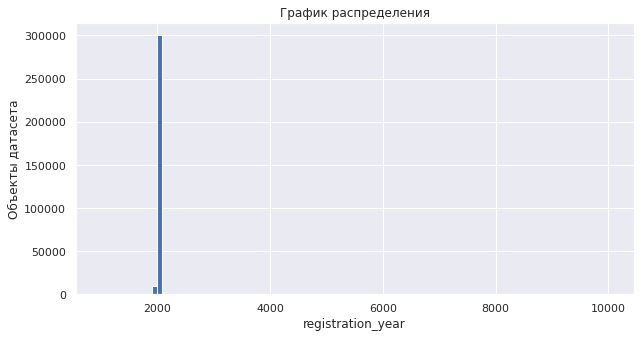

In [32]:
# первоначальный график распределения объектов в колонке 'registration_year'
print_hist_for_one_column(column_name='registration_year', bins=100)

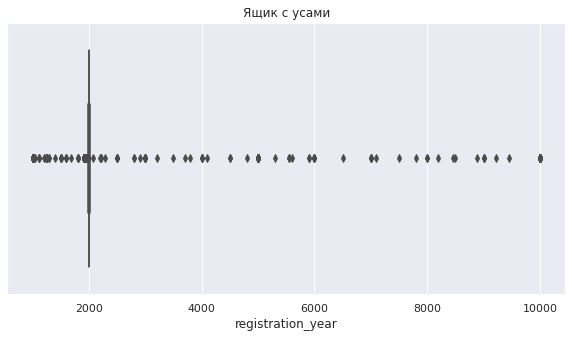

In [33]:
print_boxplot(df['registration_year'])

Удалим машины, зарегистрированные до 1971 и после 2019 годов и построим новые графики распределения объектов по годам.

In [34]:
df.drop(df.index[df['registration_year'] < 1971], inplace=True)
df.drop(df.index[df['registration_year'] > 2019], inplace=True)
print(df['registration_year'].describe())

count   307,645.00
mean      2,003.36
std           7.04
min       1,971.00
25%       1,999.00
50%       2,003.00
75%       2,008.00
max       2,019.00
Name: registration_year, dtype: float64


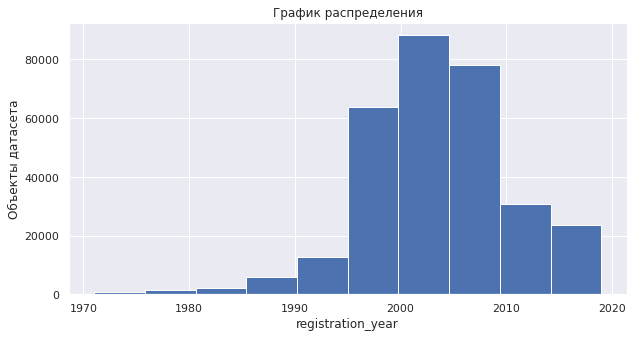

In [35]:
# нарисуем новый график распределения объектов в колонке 'registration_year'
print_hist_for_one_column(column_name='registration_year')

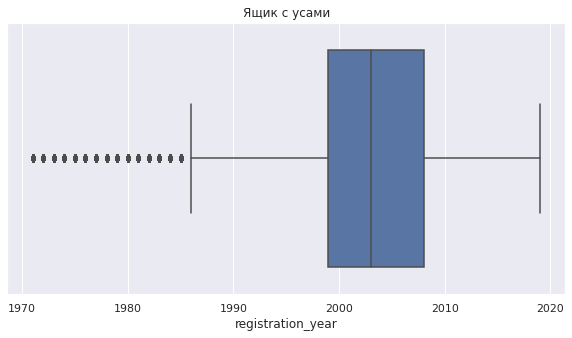

In [36]:
print_boxplot(df['registration_year'])

#### Обработка выбросов в колонке 'power'
На данный момент мощность двигателя самых мощных легковых автомобилей около 2000 л.с., но вряд ли такие машины продаются на обычных сайтах. Реалистичный диапазон мощности двигателя автомобиля для данной задачи - до 350 л.с. 99,5% автомобилей, попавших в датасет, имеет двигатель мощностью до 334 л.с. В строках с б*о*льшими значениями заменим значение на максимальное реалистичное - 350 л.с..

Нижняя граница диапазона более проблемна. Для 35199 автомобилей мощность указана в ноль лошадиных сил. Это явная ошибка.

По мнению гугла, самая маломощная машина в мире имеет мощность 4.2 л.с. В 1980 - 1990-х годах выпускались отдельные модели с мощностью ниже 15 л.с. Всего же автомобили с мощностью ниже 20 л.с. составляют 0.1% датасета, можно их проигнорировать.

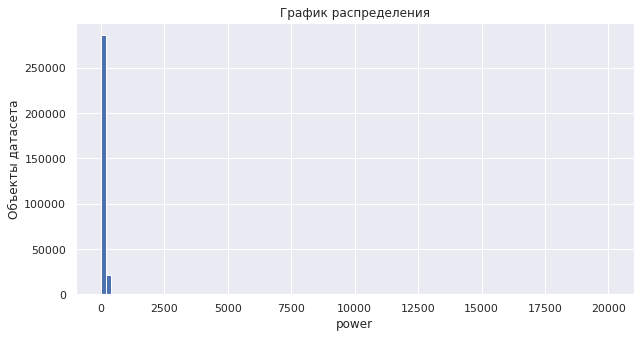

In [37]:
# построим график распределения значений в колонке 'power'
print_hist_for_one_column(column_name='power', bins=100)

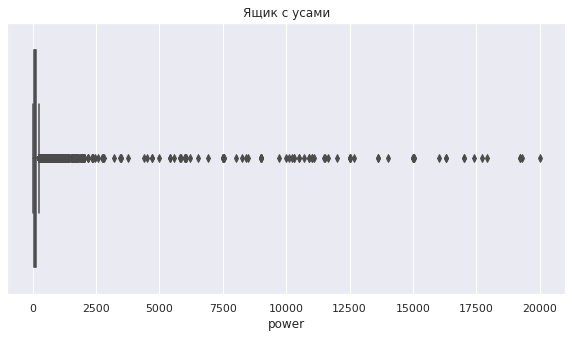

In [38]:
print_boxplot(df['power'])

In [39]:
print(df['power'].quantile(0.1))
print(df['power'].quantile(0.15))
print(df['power'].quantile(0.995))
print(df['power'].quantile(0.9975))

0.0
54.0
340.0
390.0


##### Верхняя граница

In [40]:
df[df['power'] > 350]['power'].value_counts()

450      78
367      74
354      61
387      54
400      47
         ..
850       1
851       1
871       1
19312     1
10218     1
Name: power, Length: 362, dtype: int64

In [41]:
df[df['power'] > 350]['power'].sort_values().describe()

count    1,105.00
mean     1,425.76
std      2,868.09
min        351.00
25%        387.00
50%        450.00
75%      1,005.00
max     20,000.00
Name: power, dtype: float64

##### Нижняя граница

In [42]:
df[df['power'] < 20]['power'].value_counts()

0     35199
5        96
1        30
18       28
4        26
11       26
12       16
15       15
14       12
10       12
7        11
6        11
2        10
16        9
19        9
3         8
17        7
8         6
13        5
9         4
Name: power, dtype: int64

In [43]:
df.query('power > 0 & power < 20')['power'].count() / df['power'].count()

0.0011084204196395197

In [44]:
df.query('power == 0')['power'].count()

35199

In [45]:
df.query('power == 0')['power'].count() / df['power'].count()

0.11441434120496026

In [46]:
model_mode_dict = df.groupby('model')['power'].agg(lambda x: x.mode().iloc[0]).to_dict()
print(model_mode_dict)

{'100': 133, '145': 103, '147': 105, '156': 155, '159': 150, '1_reihe': 60, '1er': 143, '200': 165, '2_reihe': 109, '300c': 218, '3_reihe': 109, '3er': 150, '4_reihe': 136, '500': 69, '5_reihe': 143, '5er': 170, '601': 26, '6_reihe': 116, '6er': 333, '7er': 286, '80': 90, '850': 144, '90': 136, '900': 150, '9000': 150, '911': 300, 'a1': 86, 'a2': 75, 'a3': 140, 'a4': 131, 'a5': 239, 'a6': 179, 'a8': 232, 'a_klasse': 82, 'accord': 155, 'agila': 75, 'alhambra': 116, 'almera': 75, 'altea': 140, 'amarok': 163, 'antara': 150, 'arosa': 50, 'astra': 75, 'auris': 124, 'avensis': 129, 'aveo': 84, 'aygo': 68, 'b_klasse': 109, 'b_max': 90, 'beetle': 116, 'berlingo': 75, 'bora': 101, 'boxster': 220, 'bravo': 120, 'c1': 68, 'c2': 60, 'c3': 73, 'c4': 109, 'c5': 136, 'c_klasse': 122, 'c_max': 109, 'c_reihe': 109, 'caddy': 105, 'calibra': 116, 'captiva': 150, 'carisma': 125, 'carnival': 144, 'cayenne': 340, 'cc': 140, 'ceed': 109, 'charade': 0, 'cherokee': 0, 'citigo': 60, 'civic': 90, 'cl': 306, 'cli

Скорректируем значение мощности.

In [47]:
# напишем функцию, корректирующую значение 'power'
def replacer(row):
    if row['power'] == 0:
        model = row['model']
        new_power = model_mode_dict[model]
    else:
        new_power = row['power']
    
    if new_power < 20:
        return 20
    elif new_power > 350:
        return 350
    else:
        return new_power

In [48]:
df['new_power'] = df.apply(lambda row: replacer(row), axis=1)
df['power'] = df['new_power']
df = df.drop('new_power', axis=1)

Проверим новое распределение значений в колонке 'power'.

In [49]:
df['power'].describe()

count   307,645.00
mean        116.58
std          54.88
min          20.00
25%          75.00
50%         109.00
75%         145.00
max         350.00
Name: power, dtype: float64

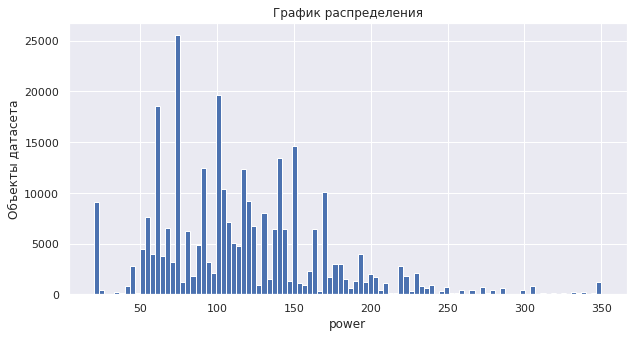

In [50]:
print_hist_for_one_column(column_name='power', bins=100)

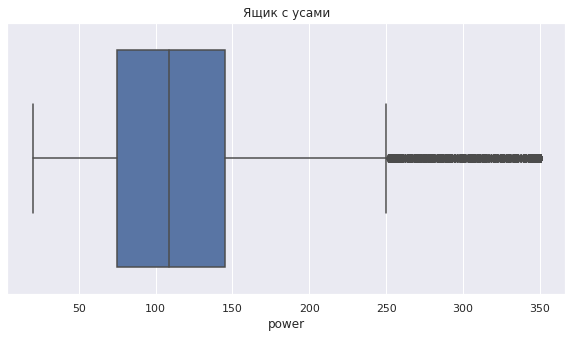

In [51]:
print_boxplot(df['power'])

#### Обработка выбросов в колонке 'price'

Проверим выбросы в колонке 'price' - это целевой признак. 

В колонке встречаются нулевые значения, такие строки составляют 2.8% от всего датасета. Восстановить эти значения не представляется возможным, оставить их тоже нельзя: это может сильно понизить точность предсказаний модели. Еще 2% приходятся на аномально низкие цены - ниже 200 EUR. Удалим эти строки.

Верхняя граница диапазона - 20_000 EUR, она не вызывает подозрения.

In [52]:
df.price.describe()

count   307,645.00
mean      4,477.21
std       4,553.70
min           0.00
25%       1,100.00
50%       2,800.00
75%       6,500.00
max      20,000.00
Name: price, dtype: float64

In [53]:
df[df['price'] == 0]['price'].count() / df['price'].count()

0.02831835394691934

In [54]:
df[df['price'] < 200]['price'].count() / df['price'].count()

0.048136651010092804

In [55]:
df.drop(df.index[df['price'] < 200], inplace=True)
df['price'].describe()

count   292,836.00
mean      4,701.55
std       4,554.02
min         200.00
25%       1,290.00
50%       2,999.00
75%       6,798.00
max      20,000.00
Name: price, dtype: float64

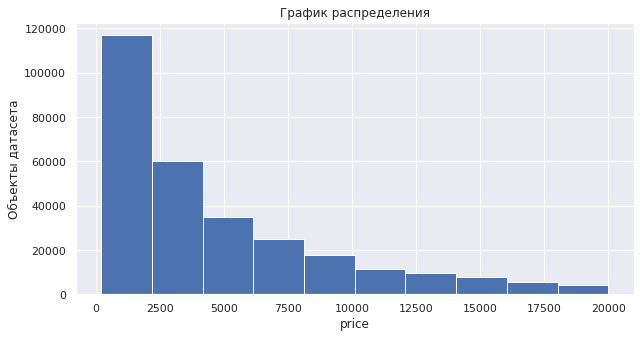

In [56]:
print_hist_for_one_column(column_name='price')

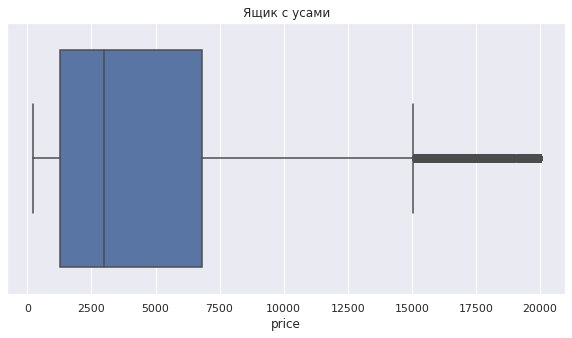

In [57]:
print_boxplot(df['price'])

### Укрупнение категориальных признаков
В датасете пять колонок с категориальными признаками. Их придется кодировать для обучения линейной регрессии. Кодировать будем методом OHE как наиболее оптимальным. 

Перед этим проверим распределение значений в категориальных колонках и укрупним категории.

In [58]:
categorical_columns

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']

In [59]:
def print_distribution(columns):
    for column in columns:
        print(column)
        print('Unique: ', len(df[column].unique()))
        print(df[column].value_counts())
        print()

In [60]:
print_distribution(categorical_columns)

vehicle_type
Unique:  9
sedan          75278
small          63698
wagon          54502
unknown        29215
bus            25295
convertible    17690
coupe          13862
suv            10479
other           2817
Name: vehicle_type, dtype: int64

gearbox
Unique:  3
manual     221915
auto        57535
unknown     13386
Name: gearbox, dtype: int64

model
Unique:  251
golf                  22483
other                 21256
3er                   16066
unknown               15375
polo                   9698
                      ...  
rangerover                4
serie_2                   4
serie_3                   3
range_rover_evoque        1
serie_1                   1
Name: model, Length: 251, dtype: int64

fuel_type
Unique:  8
petrol      178424
gasoline     83104
unknown      25642
lpg           4736
cng            505
hybrid         214
other          127
electric        84
Name: fuel_type, dtype: int64

brand
Unique:  40
volkswagen        60452
opel              31559
bmw           

В колонке 'gearbox' три уникальных значения, это не проблема. В колонке 'vehicle_type' 9 уникальных значений, но нужно объединить 'unknown' и 'other'.

In [61]:
df.loc[df['vehicle_type'] == 'other', 'vehicle_type'] = 'unknown'
df['vehicle_type'].value_counts()

sedan          75278
small          63698
wagon          54502
unknown        32032
bus            25295
convertible    17690
coupe          13862
suv            10479
Name: vehicle_type, dtype: int64

В колонке 'fuel_type' 8 уникальных значений, 'other' и 'unknown' дублируют друг друга. Объединим значения.

In [62]:
df.loc[df['fuel_type'] == 'other', 'fuel_type'] = 'unknown'
df['fuel_type'].value_counts()

petrol      178424
gasoline     83104
unknown      25769
lpg           4736
cng            505
hybrid         214
electric        84
Name: fuel_type, dtype: int64

В колонке 'brand' 40 уникальных значений, но мелких нет. Оставим их как есть.

Укрупним категории в колонке 'model'. Сначала объединим 'unknown' и 'other' - пока они друг друга дублируют.

In [63]:
df.loc[df['model'] == 'other', 'model'] = 'unknown'
print(len(df['model'].value_counts()))
df['model'].value_counts()

250


unknown               36631
golf                  22483
3er                   16066
polo                   9698
corsa                  8893
                      ...  
rangerover                4
serie_2                   4
serie_3                   3
range_rover_evoque        1
serie_1                   1
Name: model, Length: 250, dtype: int64

Из 250 уникальных категорий оставим только те, в которых не менее 1000 объектов. Осталось 51 уникальное значение. Остальные категории объединим в категорию 'other'. В данном случае она уже не дублирует 'unknown'. Теперь в колонке 'model' осталось 52 уникальных значения.

In [64]:
models_dict = df['model'].value_counts().to_dict()
prominent_models = []
for (k,v) in models_dict.items():
    if v >= 1000:
        prominent_models.append(k)
        
print(len(prominent_models))
print(prominent_models)


51
['unknown', 'golf', '3er', 'polo', 'corsa', 'astra', 'a4', 'passat', 'c_klasse', '5er', 'e_klasse', 'a3', 'focus', 'fiesta', 'a6', 'transporter', '2_reihe', 'fortwo', 'a_klasse', 'twingo', 'vectra', '1er', '3_reihe', 'mondeo', 'clio', 'touran', 'punto', 'zafira', 'megane', 'ibiza', 'ka', 'lupo', 'fabia', 'octavia', 'cooper', 'clk', 'micra', 'caddy', 'x_reihe', '80', 'scenic', 'civic', 'omega', 'sharan', 'leon', 'laguna', 'i_reihe', '6_reihe', 'slk', '1_reihe', 'galaxy']


In [65]:
aggregated_models = dict()
for (model, count) in models_dict.items():
    if count >= 1000:
        aggregated_models[model] = model
    else:
        aggregated_models[model] = 'other'
        
aggregated_models


{'unknown': 'unknown',
 'golf': 'golf',
 '3er': '3er',
 'polo': 'polo',
 'corsa': 'corsa',
 'astra': 'astra',
 'a4': 'a4',
 'passat': 'passat',
 'c_klasse': 'c_klasse',
 '5er': '5er',
 'e_klasse': 'e_klasse',
 'a3': 'a3',
 'focus': 'focus',
 'fiesta': 'fiesta',
 'a6': 'a6',
 'transporter': 'transporter',
 '2_reihe': '2_reihe',
 'fortwo': 'fortwo',
 'a_klasse': 'a_klasse',
 'twingo': 'twingo',
 'vectra': 'vectra',
 '1er': '1er',
 '3_reihe': '3_reihe',
 'mondeo': 'mondeo',
 'clio': 'clio',
 'touran': 'touran',
 'punto': 'punto',
 'zafira': 'zafira',
 'megane': 'megane',
 'ibiza': 'ibiza',
 'ka': 'ka',
 'lupo': 'lupo',
 'fabia': 'fabia',
 'octavia': 'octavia',
 'cooper': 'cooper',
 'clk': 'clk',
 'micra': 'micra',
 'caddy': 'caddy',
 'x_reihe': 'x_reihe',
 '80': '80',
 'scenic': 'scenic',
 'civic': 'civic',
 'omega': 'omega',
 'sharan': 'sharan',
 'leon': 'leon',
 'laguna': 'laguna',
 'i_reihe': 'i_reihe',
 '6_reihe': '6_reihe',
 'slk': 'slk',
 '1_reihe': '1_reihe',
 'galaxy': 'galaxy',
 

In [66]:
df['new_model'] = df['model'].map(aggregated_models)

In [67]:
print(len(df['new_model'].value_counts()))
print(len(df['model'].value_counts()))


52
250


In [68]:
df['model'] = df['new_model']
df = df.drop('new_model', axis=1)
df['model'].value_counts()

other          58620
unknown        36631
golf           22483
3er            16066
polo            9698
corsa           8893
astra           8879
a4              8009
passat          7988
c_klasse        7019
5er             6453
e_klasse        5824
a3              5135
focus           4982
fiesta          4678
a6              4676
transporter     4093
2_reihe         4089
fortwo          3921
a_klasse        3707
twingo          3661
vectra          3484
1er             3037
3_reihe         2995
mondeo          2940
clio            2927
touran          2799
punto           2650
zafira          2526
megane          2513
ibiza           2300
ka              2112
lupo            1933
fabia           1862
octavia         1846
cooper          1730
clk             1623
micra           1437
caddy           1417
x_reihe         1376
80              1287
scenic          1252
civic           1193
omega           1174
sharan          1170
leon            1164
laguna          1147
i_reihe      

In [69]:
# Проверим, что получилось в итоге
print_distribution(categorical_columns)

vehicle_type
Unique:  8
sedan          75278
small          63698
wagon          54502
unknown        32032
bus            25295
convertible    17690
coupe          13862
suv            10479
Name: vehicle_type, dtype: int64

gearbox
Unique:  3
manual     221915
auto        57535
unknown     13386
Name: gearbox, dtype: int64

model
Unique:  52
other          58620
unknown        36631
golf           22483
3er            16066
polo            9698
corsa           8893
astra           8879
a4              8009
passat          7988
c_klasse        7019
5er             6453
e_klasse        5824
a3              5135
focus           4982
fiesta          4678
a6              4676
transporter     4093
2_reihe         4089
fortwo          3921
a_klasse        3707
twingo          3661
vectra          3484
1er             3037
3_reihe         2995
mondeo          2940
clio            2927
touran          2799
punto           2650
zafira          2526
megane          2513
ibiza           2300
ka 

### Оценка предобработанного датасета

В предобработанном датасете осталось 292_836 объектов и 10 признаков (целевой и 9 обучающих). Таким образом, в результате предобработки утеряно 17.36% датасета.

Исходный датасет был очень сильно зашумлен выбросами. После предобработки корреляции стали более явными. Выявленные корреляции:
* умеренная прямая корреляция K = 0.41 между ценой (целевой признак) и годом регистрации (до предобработки K = 0.03);
* умеренная прямая корреляция K = 0.49 между ценой и мощностью автомобиля (до предобработки K = 0.16); 
* умеренная обратная корреляция K = -0.36 между ценой и пробегом автомобиля (до предобработки K = -0.36);
* слабая обратная корреляция K = -0.28 с фактом ремонтов (до предобработки эта колонка была текстовой).
* устранена ложная корреляция К = 0.11 с месяцем регистрации автомобиля, которая была в исходном датасете.

Проявившиеся корреляции выглядят правдоподобно.

Появился 1.2% дубликатов, но удалять их не будем: это результат удаления выбросов, то есть есть надежда, что эти дубликаты соответствуют характерным объектам датасета и не помешают обучению.

In [70]:
df.shape

(292836, 10)

In [71]:
(1 - len(df) / len(df_original)) * 100

17.364103519213025

In [72]:
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

In [73]:
df.describe()

,price,registration_year,power,kilometer
count,"292,836.00","292,836.00","292,836.00","292,836.00"
mean,"4,701.55","2,003.51",117.77,"127,700.33"
std,"4,554.02",6.95,54.53,"37,587.48"
min,200.00,"1,971.00",20.00,"5,000.00"
25%,"1,290.00","1,999.00",75.00,"125,000.00"
50%,"2,999.00","2,003.00",109.00,"150,000.00"
75%,"6,798.00","2,008.00",147.00,"150,000.00"
max,"20,000.00","2,019.00",350.00,"150,000.00"


In [74]:
round(df.duplicated().mean(), 3)

0.012

,price,registration_year,power,kilometer,repaired
price,1.00,0.41,0.49,-0.36,-0.28
registration_year,0.41,1.00,0.08,-0.23,-0.09
power,0.49,0.08,1.00,0.12,-0.13
kilometer,-0.36,-0.23,0.12,1.00,0.10
repaired,-0.28,-0.09,-0.13,0.10,1.00


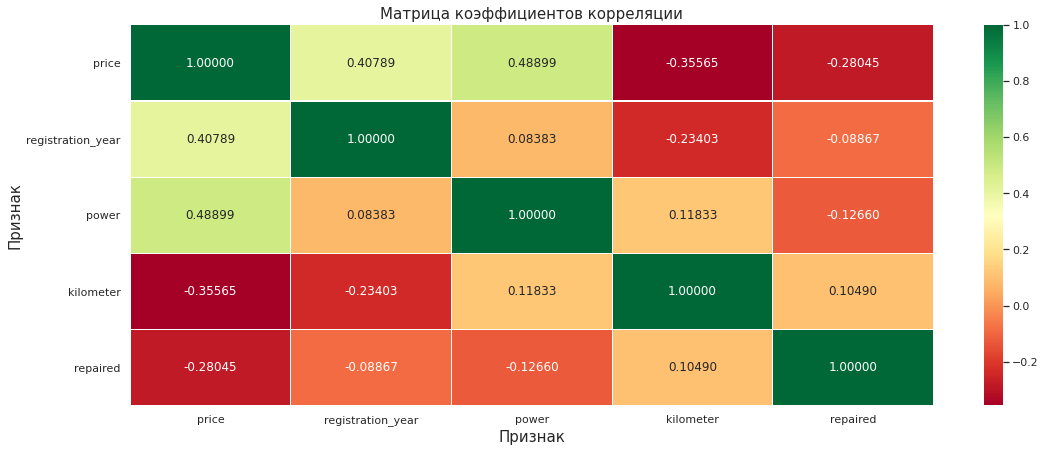

In [75]:
# в предобработанном датасете
display(df.corr())
correlation_heatmap(df.corr())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
Price,1.00,0.03,0.16,-0.33,0.11
RegistrationYear,0.03,1.00,-0.00,-0.05,-0.01
Power,0.16,-0.00,1.00,0.02,0.04
Kilometer,-0.33,-0.05,0.02,1.00,0.01
RegistrationMonth,0.11,-0.01,0.04,0.01,1.00


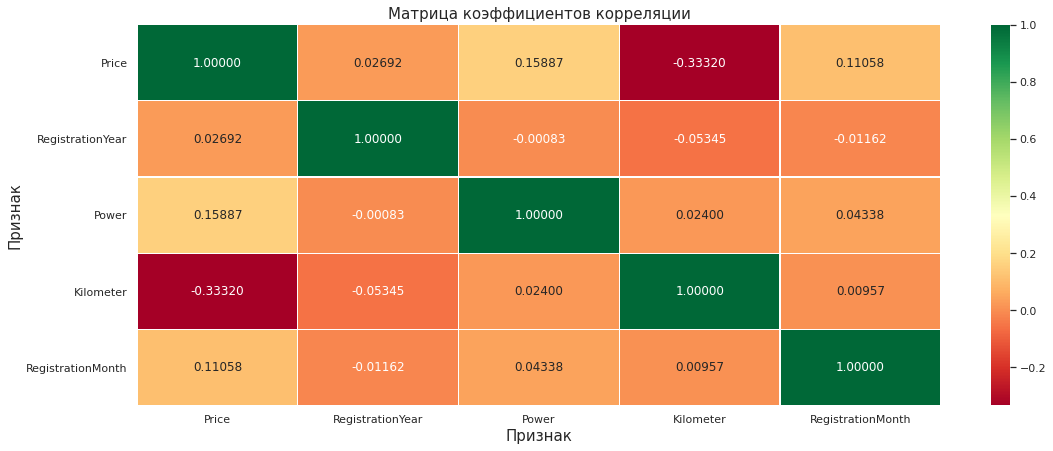

In [76]:
# в исходном датасете
display(df_original.drop(['NumberOfPictures', 'PostalCode'], axis=1).corr())
correlation_heatmap(df_original.drop(['NumberOfPictures', 'PostalCode'], axis=1).corr())

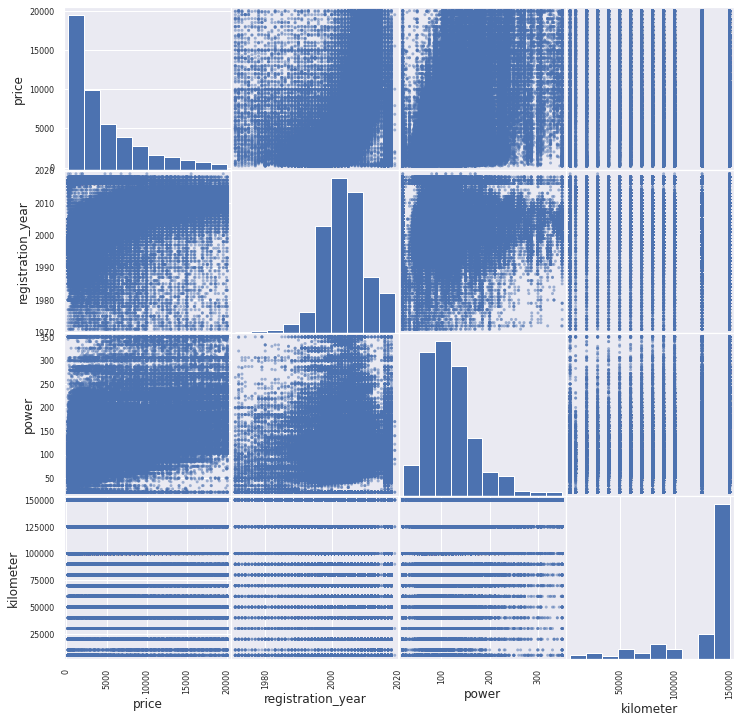

In [77]:
# в предобработанном датасете:
scatter_matrix(df.drop('repaired', axis=1))

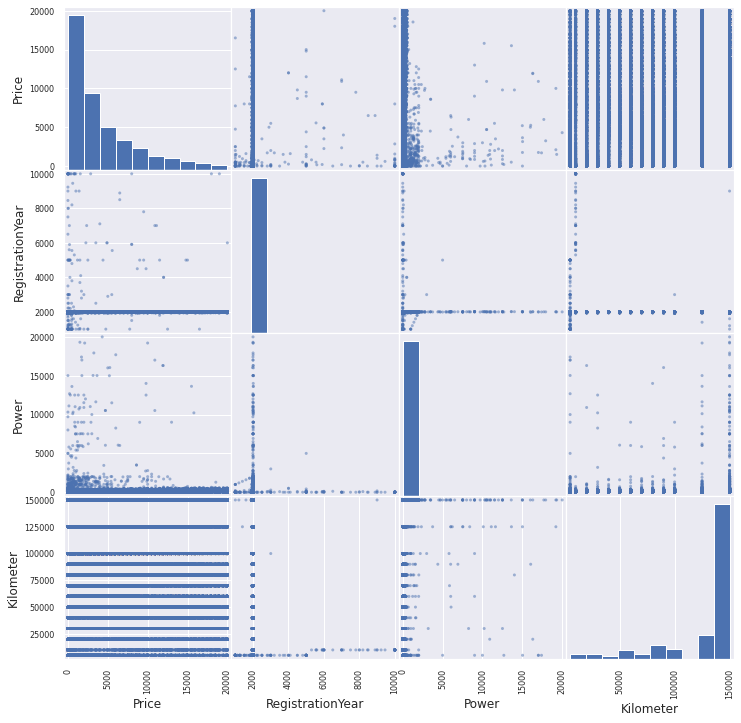

In [78]:
# в исходном датасете:
scatter_matrix(df_original.drop(['NumberOfPictures', 'PostalCode', 'RegistrationMonth'], axis=1))

### Вывод по этапу предобработки данных
#### Преобразования
В ходе предобработки данных было сделано:
* переименование колонок в snake_case;
* удаление неинформативных столбцов: 
    - 'crawled_at' (дата скачивания анкеты)
    - 'created_at' (дата создания анкеты)
    - 'last_seen_at' (время последней активности владельца)
    - 'number_of_pictures' (количество изображений)
    - 'postal_code' (почтовый индекс владельца)
* удаление дубликатов (4 полных дубликата в исходном датасете и еще 45046 дубликатов, появившихся после удаления неинформативных столбцов);
* заполнение отсутствующих значений:
    - в колонках 'vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand' пустые значения были изменены на 'unknown'
    - в колонке 'repaired' - на 'no' (отсутствие ремонта)
* преобразование типов колонок: значения в колонке 'repaired' после замены пустых значений на 'no' были сначала заменены на 1 и 0, а затем переведены в тип boolean;
* обработка выбросов:
    - выбросы в колонке 'registered_at':
        - строки со значениями меньше 1971 года удалены как антиквариат или как ошибочные значения (с ними удалено 0.5% датасета); 
        - строки со значениями больше 2019 года удалены как ошибочные значения (с ними удалено еще 0.5% датасета)
    - выбросы в колонке 'power' (мощность двигателя):
        - нулевые значения заменены на моду, рассчитанную по модели автомобиля;
        - значения меньше 20 л.с. заменены на 20 л.с.;
        - значения больше 350 л.с. заменены на 350 л.с.
    - выбросы в колонке 'price' (целевой признак): 
        - строки с выбросами удалены
* укрупнение категориальных признаков:
    - убрано дублирование значение 'unknown' и 'other' в категориальных колонках;
    - в колонке 'model' (модель автомобиля) уникальные значения, которым соответствует меньше 1000 объектов, объединены в одну группу - 'other', в результате в колонке осталось 52 уникальных значений, что важно для последующего кодирования методом OHE

#### Сводные данные по итоговому датасету
В предобработанном датасете осталось 292_836 объектов и 10 признаков (целевой и 9 обучающих), среди них: 
* 5 категориальных: 'vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand'
* 3 числовых: 'registration_year', 'power', 'kilometer'
* 1 двоичный: 'repaired'
* и целевой: 'price'

#### Анализ закономерностей в итоговом датасете
Исходный датасет был очень сильно зашумлен выбросами. После предобработки корреляции стали более явными. Выявленные корреляции:

* умеренная прямая корреляция K = 0.41 между ценой (целевой признак) и годом регистрации (до предобработки K = 0.03);
* умеренная прямая корреляция K = 0.49 между ценой и мощностью автомобиля (до предобработки K = 0.16);
* умеренная обратная корреляция K = -0.36 между ценой и пробегом автомобиля (до предобработки K = -0.36);
* слабая обратная корреляция K = -0.28 с фактом ремонтов (до предобработки эта колонка была текстовой).
* устранена ложная корреляция К = 0.11 с месяцем регистрации автомобиля, которая была в исходном датасете.


## Подготовка выборок для обучения моделей


### Подготовка датасетов
#### Разделение датасета на тренировочный, валидационный и тестовый
Подготовим выборки. Разделим датасет на тренировочный, валидационный и тестовый. Эти датасеты пригодны для обучения CatBoost моделей, т.к. они могут работать с категориальными признаками напрямую.

In [79]:
features = df.drop(['price'], axis=1)
target = df['price']

features_train, features_test_and_valid, target_train, target_test_and_valid = train_test_split(
    features, target, test_size=0.4, random_state=666)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_test_and_valid, target_test_and_valid, test_size=0.5, random_state=666)

print('Количество объектов в features_train:', len(features_train))
print('Количество объектов в target_train:', len(target_train))

print('Количество объектов в features_valid:', len(features_valid))
print('Количество объектов в target_valid:', len(target_valid))

print('Количество объектов в features_test:', len(features_test))
print('Количество объектов в target_test:', len(target_test))

Количество объектов в features_train: 175701
Количество объектов в target_train: 175701
Количество объектов в features_valid: 58567
Количество объектов в target_valid: 58567
Количество объектов в features_test: 58568
Количество объектов в target_test: 58568


### Масштабирование численных признаков
Масштабируем численные признаки.

In [80]:
scaler = StandardScaler()
scaler.fit(features_train[numerical_columns])

for dataset in [features_train, features_valid, features_test]:
    dataset[numerical_columns] = scaler.transform(dataset[numerical_columns])

features_train.head()

/tmp/ipykernel_31/33453506.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[numerical_columns] = scaler.transform(dataset[numerical_columns])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_31/33453506.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
321205,sedan,-0.07,manual,-0.66,a_klasse,0.59,gasoline,mercedes_benz,True
2026,sedan,0.36,manual,-0.14,3_reihe,-3.26,unknown,mazda,False
118763,small,-0.50,manual,-0.91,other,0.59,petrol,toyota,True
10322,sedan,-0.07,manual,-0.14,civic,-1.00,petrol,honda,False
49321,bus,0.36,auto,-0.03,golf,-1.00,petrol,volkswagen,False


#### Изменение типа категориальных колонок для LightGBM
CatBoost способен работать с категориальными данными напрямую благодаря встроенному преобразованию данных. А для LightGBM нужно заменить тип категориальных колонок с 'object' на 'category'. 


In [81]:
features_train_lgb = features_train
features_valid_lgb = features_valid
features_test_lgb = features_test

for column in categorical_columns:
    features_train_lgb[column] = features_train_lgb[column].astype('category')
    features_valid_lgb[column] = features_valid_lgb[column].astype('category')
    features_test_lgb[column] = features_test_lgb[column].astype('category')

/tmp/ipykernel_31/3357692247.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train_lgb[column] = features_train_lgb[column].astype('category')
/tmp/ipykernel_31/3357692247.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_valid_lgb[column] = features_valid_lgb[column].astype('category')
/tmp/ipykernel_31/3357692247.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

#### Подготовка датасетов с кодированием категориальных признаков для линейной регрессии
Для линейной регрессии нужно будет кодировать категориальные признаки. Сделаем это методом OHE, как наиболее универсальным.

In [430]:
features_train_test = features_train.copy()
features_valid_test = features_valid.copy()
features_test_test = features_test.copy()

In [ ]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False, dtype='int32')
ohe.fit(features_train[categorical_columns])

def get_ohe(dataset):
    temp_dataset = pd.DataFrame(
        data=ohe.transform(dataset[categorical_columns]), 
        columns=ohe.get_feature_names_out())
 
    dataset.drop(columns=categorical_columns, axis=1, inplace=True)
    
    dataset = pd.concat([dataset.reset_index(drop=True), temp_dataset], axis=1)
    return dataset

In [432]:
features_train.head()

In [433]:
features_train_ohe = features_train.copy()
features_valid_ohe = features_valid.copy()
features_test_ohe = features_test.copy()

features_train_ohe = get_ohe(features_train_ohe)
features_valid_ohe = get_ohe(features_valid_ohe)
features_test_ohe = get_ohe(features_test_ohe)

In [434]:
for dataset in [features_train_ohe, features_valid_ohe, features_test_ohe]:
    display(dataset.head())

In [435]:
# проверим, что колонки совпали
print(features_train_ohe.columns == features_valid_ohe.columns)
print(features_valid_ohe.columns == features_test_ohe.columns)

In [436]:
features_train_ohe.info()

Получился датасет из 152 колонок (хорошо, что уменьшили количество уникальных значений в категориальных колонках).

## Обучение моделей
Обучим модели на подготовленных датасетах.

Результат оценивается по метрике RMSE - это корень из среднего квадрата ошибок. Его имеет смысл сравнивать со средним стандартным отклонением. Среднее стандартное отклонение в датасете - 4_554.02 EUR.

In [437]:
df['price'].describe()

### CatBoost
Инициализируем и обучим модель CatBoost.
#### CatBoost без параметров
Попробуем использовать модель с дефолтными параметрами. Модель обучилась за 1 минуту 22 секунд, RMSE = 1704.30 EUR.

In [438]:
%%time
catboost_model = CatBoostRegressor(verbose=0, random_seed=666)
catboost_model.fit(features_train, target_train, cat_features=categorical_columns)

In [439]:
%%time
predictions_valid_catboost = catboost_model.predict(features_valid)

In [440]:
catboost_rmse = mean_squared_error(target_valid, predictions_valid_catboost, squared=False)
print('RMSE модели CatBoost: ', catboost_rmse)

#### Catboost с параметром iterations=10
Попробуем уменьшить время обучения и задать модели параметр `iterations=10`. Время обучения уменьшилось, но результат ухудшился: RMSE = 2008.50 EUR.

In [441]:
%%time
catboost_model_10_iterations = CatBoostRegressor(verbose=0, iterations=10, random_seed=666)
catboost_model_10_iterations.fit(features_train, target_train, cat_features=categorical_columns)

In [442]:
%%time
predictions_valid_catboost_10_iterations = catboost_model_10_iterations.predict(features_valid)

In [443]:
catboost_rmse_10_iterations = mean_squared_error(target_valid, predictions_valid_catboost_10_iterations, squared=False)
print('RMSE модели CatBoost: ', catboost_rmse_10_iterations)

#### CatBoost c параметрами iterations=100, max_depth=10
Попробуем сократить количество итераций менее радикально, зато зададим максимальную глубину дерева. Время обучения - 5.9 секунд, результат все равно хуже, чем у модели без параметров: RMSE = 1728.92 EUR.

In [444]:
%%time
catboost_model_100_iter_10_depth = CatBoostRegressor(loss_function="RMSE", iterations=100, max_depth=10, verbose=0, random_seed=666)
catboost_model_100_iter_10_depth.fit(features_train, target_train, cat_features=categorical_columns)

In [445]:
%%time
predictions_valid_catboost_100_iter_10_depth = catboost_model_100_iter_10_depth.predict(features_valid)

In [446]:
catboost_rmse_100_iter_10_depth = mean_squared_error(target_valid, predictions_valid_catboost_100_iter_10_depth, squared=False)
print('RMSE модели CatBoost: ', catboost_rmse_100_iter_10_depth)

### LightGBM
Инициализируем и обучим модель LightGBM.
#### LightGBM с дефолтными настройками
Модель обучалась чуть меньше секунды, RMSE = 1746.17 EUR.

In [447]:
lgb_model = lgb.LGBMRegressor(categorical_feature=categorical_columns, random_state=666)

In [448]:
%%time
lgb_model.fit(features_train_lgb, target_train, categorical_feature=categorical_columns)

In [449]:
%%time
predictions_valid_lgb = lgb_model.predict(features_valid_lgb)

In [450]:
lgb_rmse = mean_squared_error(target_valid, predictions_valid_lgb, squared=False)
print('RMSE модели LGB: ', lgb_rmse)

#### LightGBM с параметрами 
Попробуем ускорить обучение модели, передав ей ограничивающие параметры.
Модель обучалась 1 секунду, но ухудшился RMSE = 2093.20 EUR.

In [451]:
lgb_model_lim = lgb.LGBMRegressor(loss_function='RMSE', categorical_feature=categorical_columns, n_estimators=20, max_depth=5, random_state=666)

In [452]:
%%time
lgb_model_lim.fit(features_train_lgb, target_train, categorical_feature=categorical_columns)

In [453]:
%%time
predictions_valid_lgb_lim = lgb_model_lim.predict(features_valid_lgb)

In [454]:
lgb_rmse_lim = mean_squared_error(target_valid, predictions_valid_lgb_lim, squared=False)
print('RMSE модели LGB c ограничивающими параметрами: ', lgb_rmse_lim)

#### LightGBM с другими параметрами
Попробуем задать модели другой набор параметров, ограничив количество деревьев-оценщиков, максимальную глубину дерева и количество листьев. И это лучший результат RMSE = 1668.28 EUR. Время обучения остается приемлемым - 1.8 секунды. 

In [455]:
lgb_model_lim_2 = lgb.LGBMRegressor(n_estimators=200, max_depth = 10, num_leaves = 100, random_state=666)

In [456]:
%%time
lgb_model_lim_2.fit(features_train_lgb, target_train, categorical_feature=categorical_columns)

In [457]:
%%time
predictions_valid_lgb_lim_2 = lgb_model_lim_2.predict(features_valid_lgb)

In [458]:
lgb_rmse_lim_2 = mean_squared_error(target_valid, predictions_valid_lgb_lim_2, squared=False)
print('RMSE модели LGB c ограничивающими параметрами: ', lgb_rmse_lim_2)

### Линейная регрессия
Обучим линейную регрессию.

Сначала на датасете с закодированными категориальными признаками:

In [459]:
%%time

regression_model = LinearRegression()
regression_model.fit(features_train_ohe, target_train)
predictions_valid_ohe = regression_model.predict(features_valid_ohe)

regression_rmse_ohe = mean_squared_error(target_valid, predictions_valid_ohe, squared=False)
print('RMSE линейной регрессии: ', regression_rmse_ohe)

Потом на датасете вообще без категориальных признаков:

In [460]:
no_cats_columns = numerical_columns
no_cats_columns.append('repaired')
no_cats_columns

In [461]:
%%time

regression_model_no_cats = LinearRegression()
regression_model_no_cats.fit(features_train[no_cats_columns], target_train)
predictions_valid_no_cats = regression_model_no_cats.predict(features_valid[no_cats_columns])

regression_rmse_no_cats = mean_squared_error(target_valid, predictions_valid_no_cats, squared=False)
print('RMSE линейной регрессии: ', regression_rmse_no_cats)

В обоих случаях получаем неприемлемо высокий RMSE = 2762.43 EUR и RMSE = 3195.14 EUR.

## Сравнение моделей и выбор лучшей модели
### Сравнение моделей
Сравнительные результаты работы моделей приведены в таблице.

In [462]:
data = {'models': ['catboost_model', 
                   'catboost_model_10_iterations', 
                   'catboost_model_100_iter_10_depth',
                   'lgb_model',
                   'lgb_model_lim',
                   'lgb_model_lim_2',
                   'regression_model',
                   'regression_model_no_cats'], 
        'rmse': [catboost_rmse, 
                 catboost_rmse_10_iterations,
                 catboost_rmse_100_iter_10_depth,
                 lgb_rmse,
                 lgb_rmse_lim,
                 lgb_rmse_lim_2,
                 regression_rmse_ohe,
                 regression_rmse_no_cats]}
results = pd.DataFrame(data=data)
results

Из таблицы видим, что CatBoost с дефолтными настройками справилась с задачей лучше, чем LightGBM c дефолтными настройками: RMSE 1704.30 EUR против 1746.17 EUR. Время обучения CatBoost около полутора минут против 1 секунды у LightGBM.

Хуже всего результаты у линейной регрессии.

Лучше всего показала себя модель LightGBM с кастомными параметрами: 

In [463]:
lgb_model_lim_2

На валидационной выборке она показала RMSE = 1668.28 EUR. Время обучения - 1.81 секунд. Время предсказания - 486 милисекунд. 



### Проверка лучшей модели на тестовом датасете
Проверим выбранную модель на тестовом датасете.

In [464]:
%%time
predictions_test_lgb_lim_2 = lgb_model_lim_2.predict(features_test_lgb)

In [465]:
lgb_rmse_lim_2_test = mean_squared_error(target_test, predictions_test_lgb_lim_2, squared=False)
print('RMSE модели LGB c ограничивающими параметрами: ', lgb_rmse_lim_2_test)

На тестовом датасете выбранная модель показала RMSE = 1647.31 EUR. Модель сделала предсказания за 477 милисекунд.

## Вывод
В ходе проекта была решена задача предсказания рыночной стоимости автомобиля для сайта по продаже подержанных автомобилей.

Для решения задачи был использован датасет с данными о параметрах и фактической стоимости подержанных автомобилей. В исходном датасете было 16 колонок и 354369 строк.

Была проведена предобработка данных: удаление неинформативных столбцов, удаление дубликатов, заполнение отсутствующих значений, обработка выбросов, преобразование типов колонок. В предобработанном датасете осталось 292_836 объектов и 10 признаков (целевой и 9 обучающих).

В категориальной колонке 'model' было проведено укрупнение категорий, оставлены 52 уникальные категории, каждой из которых соответствует не менее 1000 объектов в исходном датасете. Замечено, что граница, по которой отсекаются мелкие категории, сильно влияет на точность предсказаний: при более низкой границе отсечения (200 и 500 объектов) RMSE было ниже, однако становилось выше время обучения моделей.

Предобработанный датасет был разделен на тренировочный, валидационный и тестовый датасеты для дальнейшего обучения моделей.

Для решения задачи предсказания цены автомобиля были обучены модели LinearRegression, CatBoost и LightGBM с различными параметрами. 

Целевой метрикой для определения лучшей модели являлось RMSE - корень из средней квадратичной ошибки. Оценивая результат, следует иметь в виду, что стандартное отклонение целевого признака в исходном датасете - 4_514.16 EUR.

Обученные модели показали следующие результаты:

In [466]:
results

In [469]:
df_original['Price'].describe()

Наилучший результат показала модель LightGBM со следующими параметрами:

In [467]:
lgb_model_lim_2

На валидационной выборке она показала RMSE = 1668.28 EUR. Время обучения - 1.81 секунд. Время предсказания - 486 милисекунд. На тестовом датасете выбранная модель показала RMSE = 1647.31 EUR. Модель сделала предсказания за 477 милисекунд.

Данная модель рекомендуется для дообучения и дальнейшего использования.